In [1]:
!pip install meteostat pandas scikit-learn tensorflow statsmodels

In [2]:
import pandas as pd
from meteostat import Point, Daily
from datetime import datetime
import matplotlib.pyplot as plt

# Definir las coordenadas de las ciudades
cities = {
    'Alicante': Point(38.3452, -0.4810),
    'Palma': Point(39.5696, 2.6502),
    'Las Palmas': Point(28.1235, -15.4363),
    'Girona': Point(41.9818, 2.8249),
    'Malaga': Point(36.7213, -4.4216)
}

# Definir el rango de fechas
start = datetime(2010, 1, 1)
end = datetime(2023, 12, 31)

# Crear una lista para almacenar los datos de todas las ciudades
all_data_list = []

# Obtener los datos de cada ciudad y concatenar en un solo DataFrame
for city, point in cities.items():
    # Obtener los datos diarios de Meteostat
    data = Daily(point, start, end)
    data = data.fetch()
    
    # Agregar columna para la ciudad
    data['city'] = city
    
    # Agregar los datos a la lista
    all_data_list.append(data)

# Concatenar todos los datos en un solo DataFrame
all_data = pd.concat(all_data_list).reset_index()

# Resamplear los datos a frecuencia mensual 'MS' y calcular la media
all_data['time'] = pd.to_datetime(all_data['time'])
all_data.set_index('time', inplace=True)
datos_todo = all_data.groupby('city').resample('MS').mean().reset_index()

# Visualización de los datos
print(datos_todo.head())
datos_todo.shape

       city       time       tavg       tmin       tmax      prcp  snow  \
0  Alicante 2010-01-01  12.470968   6.974194  15.019355  1.310714   NaN   
1  Alicante 2010-02-01  11.882143   7.217857  16.464286  0.670370   NaN   
2  Alicante 2010-03-01  12.748387   7.809677  17.177419  1.180000   NaN   
3  Alicante 2010-04-01  15.806667  10.760000  19.966667  0.483333   NaN   
4  Alicante 2010-05-01  18.761290  13.174194  23.335484  0.892857   NaN   

         wdir       wspd  wpgt         pres  tsun  
0  220.920000  14.890323   NaN  1014.580645   NaN  
1  255.818182  12.189286   NaN  1008.910714   NaN  
2  203.952381  11.229032   NaN  1018.053571   NaN  
3  122.095238  10.816667   NaN  1017.375862   NaN  
4  208.294118  10.751613   NaN  1014.441935   NaN  


(840, 12)

Regresión Lineal para Alicante - RMSE: 5.52
coeficiente [0.00653739]


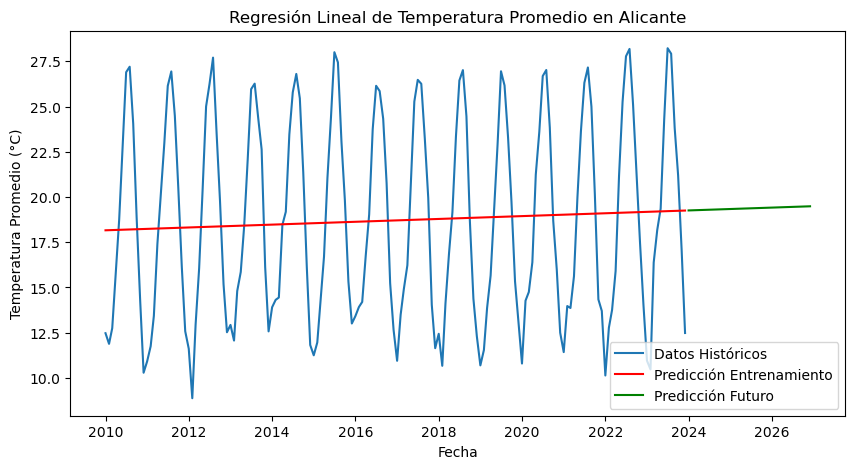

Regresión Lineal para Palma - RMSE: 5.81
coeficiente [0.01317471]


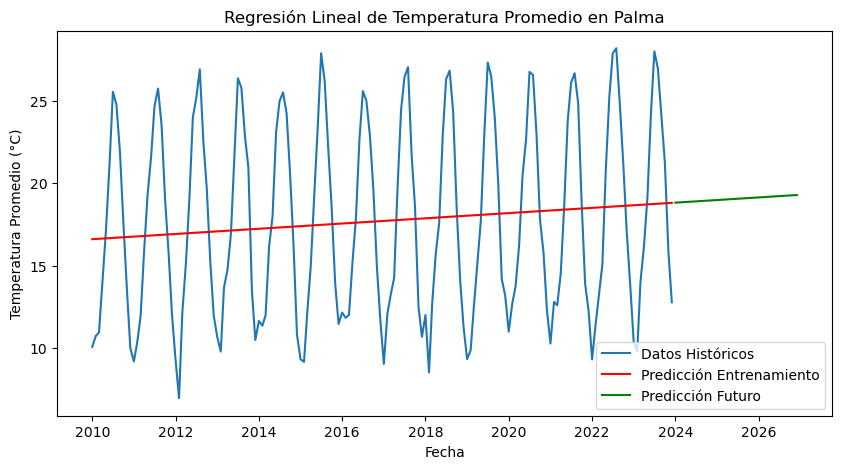

Regresión Lineal para Las Palmas - RMSE: 2.48
coeficiente [0.00377038]


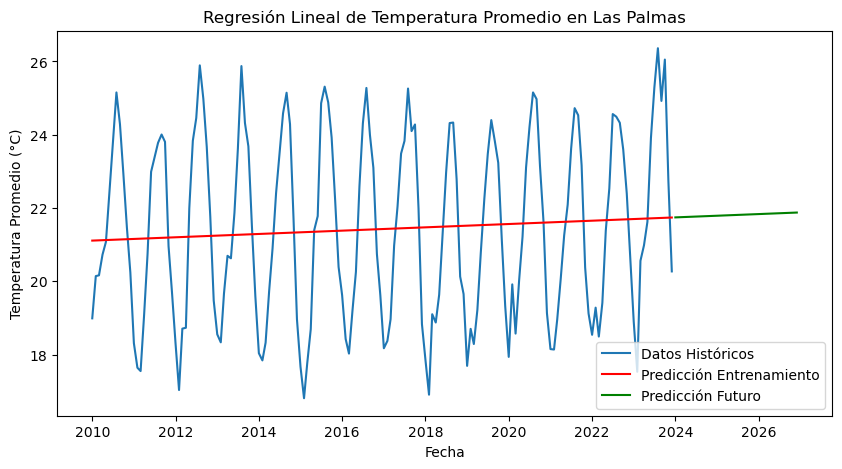

Regresión Lineal para Girona - RMSE: 6.15
coeficiente [0.00905946]


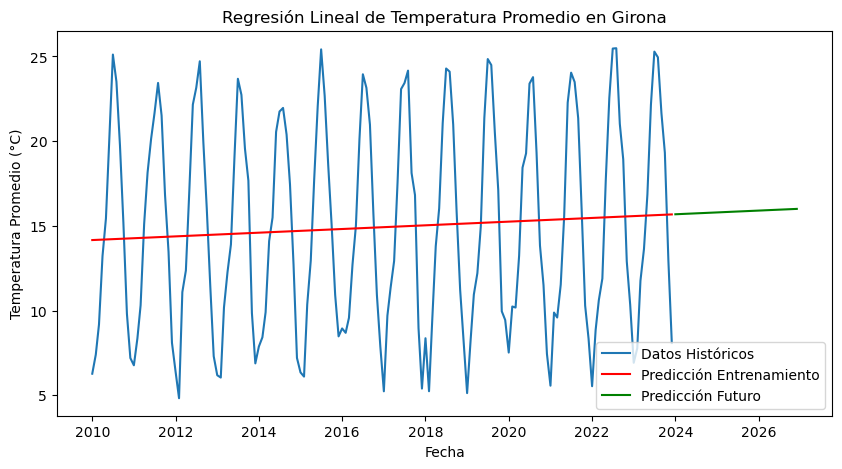

Regresión Lineal para Malaga - RMSE: 5.06
coeficiente [0.00803061]


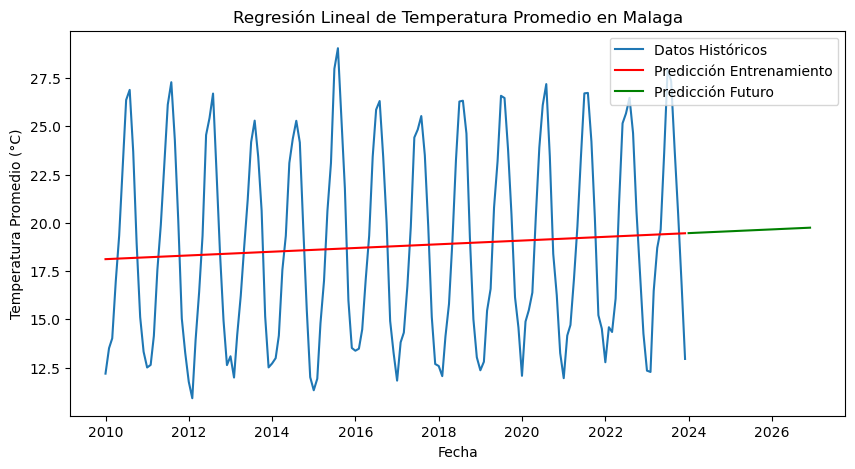

In [7]:
#Regresión lineal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

def preparar_datos_regresion(data, ciudad):
    ciudad_data = data[data['city'] == ciudad].set_index('time')
    X = np.array((ciudad_data.index.year * 12 + ciudad_data.index.month).values).reshape(-1, 1)
    y = ciudad_data['tavg'].values
    return X, y, ciudad_data.index

# Definir un DataFrame para almacenar las predicciones
predicciones_regresion = pd.DataFrame()

# Aplicar el modelo de regresión lineal para cada ciudad
for city in cities.keys():
    X, y, dates = preparar_datos_regresion(datos_todo, city)
    model = LinearRegression().fit(X, y)
    
    # Predicciones para los años 2024, 2025 y 2026
    future_X = np.array([(year * 12 + month) for year in range(2024, 2027) for month in range(1, 13)]).reshape(-1, 1)
    future_dates = pd.date_range(start='2024-01-01', end='2026-12-01', freq='MS')
    future_pred = model.predict(future_X)
    
    # Calcular el accuracy
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    # Agregar las predicciones al DataFrame
    df_pred = pd.DataFrame({'time': future_dates, 'tavg': future_pred, 'city': city})
    predicciones_regresion = pd.concat([predicciones_regresion, df_pred])
    
    print(f'Regresión Lineal para {city} - RMSE: {rmse:.2f}')
    print("coeficiente", model.coef_)
    
    # Graficar resultados
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y, label='Datos Históricos')
    plt.plot(dates, y_pred, label='Predicción Entrenamiento', color='red')
    plt.plot(future_dates, future_pred, label='Predicción Futuro', color='green')
    plt.xlabel('Fecha')
    plt.ylabel('Temperatura Promedio (°C)')
    plt.title(f'Regresión Lineal de Temperatura Promedio en {city}')
    plt.legend()
    plt.show()






1/1 [==============================] - 0s 28ms/step
RNN para Alicante - RMSE: 1.03


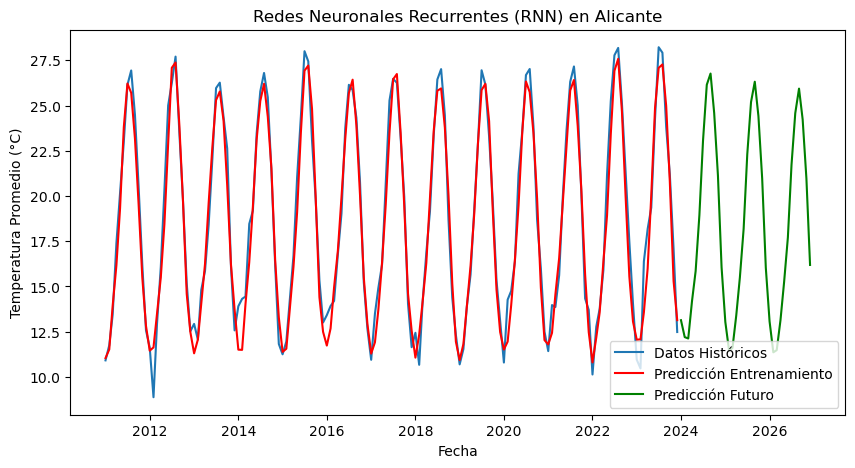

1/1 [==============================] - 0s 35ms/step
RNN para Palma - RMSE: 0.96


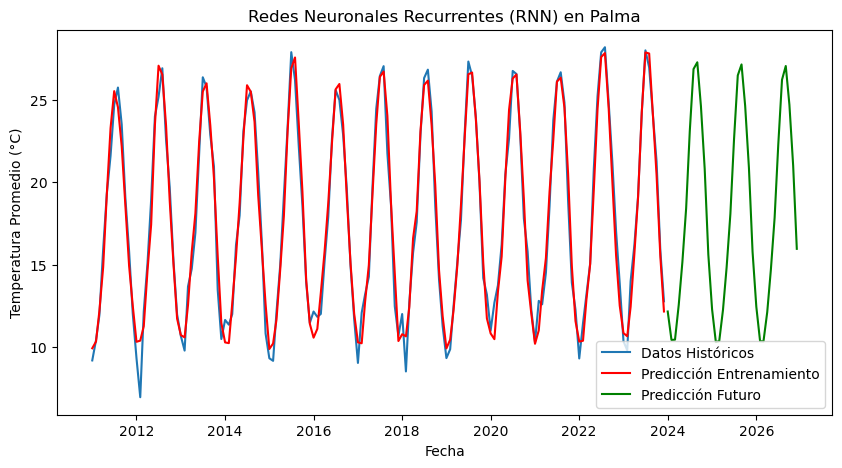

1/1 [==============================] - 0s 45ms/step
RNN para Las Palmas - RMSE: 0.56


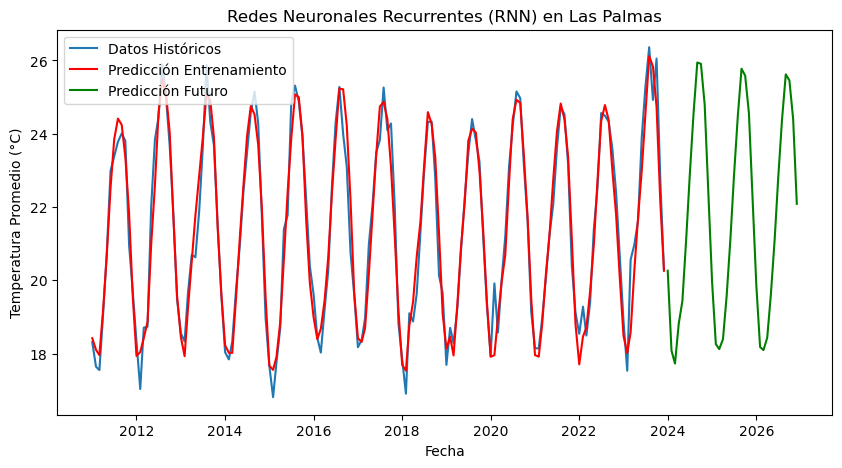

1/1 [==============================] - 0s 47ms/step
RNN para Girona - RMSE: 1.22


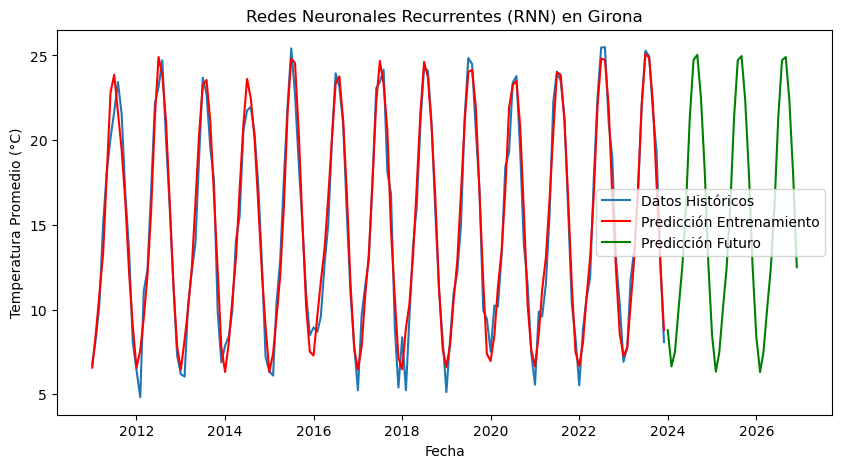

1/1 [==============================] - 0s 47ms/step
RNN para Malaga - RMSE: 0.78


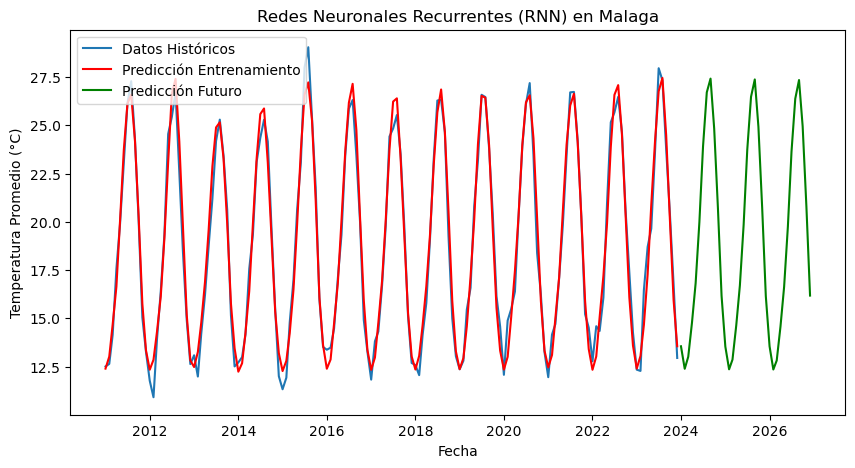

In [8]:
#Redes Neuronales Recurrentes: RNN
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def preparar_datos_rnn(data, ciudad):
    ciudad_data = data[data['city'] == ciudad].set_index('time')
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(ciudad_data[['tavg']])

    X, y = [], []
    for i in range(12, len(scaled_data)):
        X.append(scaled_data[i-12:i])
        y.append(scaled_data[i])
    
    X = np.array(X)
    y = np.array(y)
    return X, y, scaler, ciudad_data.index

# Definir un DataFrame para almacenar las predicciones
predicciones_rnn = pd.DataFrame()

# Aplicar el modelo RNN para cada ciudad
for city in cities.keys():
    X, y, scaler, dates = preparar_datos_rnn(datos_todo, city)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)
    
    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(scaler.inverse_transform(y), y_pred)
    rmse = np.sqrt(mse)
    
    # Predicciones para los años 2024, 2025 y 2026
    future_pred = []
    future_X = X[-1].reshape(1, X.shape[1], X.shape[2])
    
    for _ in range(36):
        next_pred = model.predict(future_X)
        future_pred.append(next_pred[0, 0])
        next_input = np.append(future_X[0, 1:], next_pred)
        future_X = next_input.reshape(1, X.shape[1], X.shape[2])
    
    future_pred = scaler.inverse_transform(np.array(future_pred).reshape(-1, 1)).flatten()
    future_dates = pd.date_range(start='2024-01-01', end='2026-12-01', freq='MS')
    
    # Agregar las predicciones al DataFrame
    df_pred = pd.DataFrame({'time': future_dates, 'tavg': future_pred, 'city': city})
    predicciones_rnn = pd.concat([predicciones_rnn, df_pred])
    
    print(f'RNN para {city} - RMSE: {rmse:.2f}')
    
    # Graficar resultados
    plt.figure(figsize=(10, 5))
    plt.plot(dates[12:], scaler.inverse_transform(y), label='Datos Históricos')
    plt.plot(dates[12:], y_pred, label='Predicción Entrenamiento', color='red')
    plt.plot(future_dates, future_pred, label='Predicción Futuro', color='green')
    plt.xlabel('Fecha')
    plt.ylabel('Temperatura Promedio (°C)')
    plt.title(f'Redes Neuronales Recurrentes (RNN) en {city}')
    plt.legend()
    plt.show()


Resumen del modelo ARIMA para Alicante:
                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -374.755
Date:                Sat, 15 Jun 2024   AIC                            755.509
Time:                        16:32:52   BIC                            764.863
Sample:                    01-01-2010   HQIC                           759.306
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6023      0.104      5.765      0.000       0.398       0.807
ma.L1          0.1437      0.116      1.236      0.217      -0.084       0.372
sigma2      

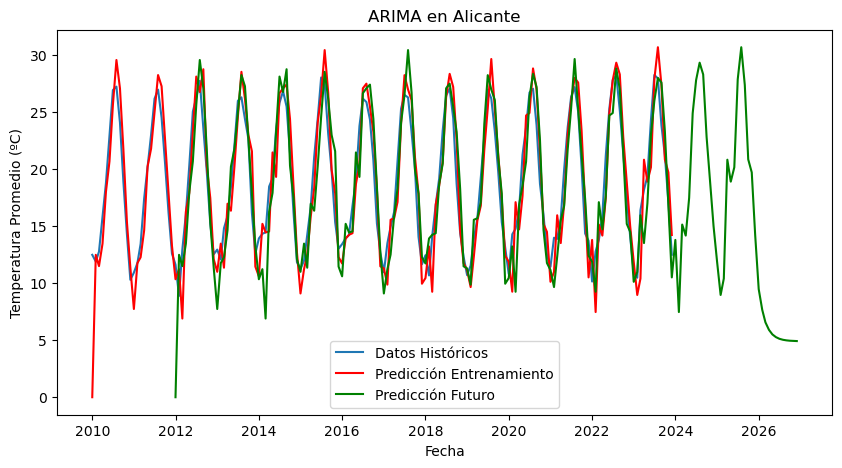

Resumen del modelo ARIMA para Palma:
                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -385.596
Date:                Sat, 15 Jun 2024   AIC                            777.192
Time:                        16:32:55   BIC                            786.546
Sample:                    01-01-2010   HQIC                           780.988
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5967      0.103      5.817      0.000       0.396       0.798
ma.L1          0.1235      0.128      0.966      0.334      -0.127       0.374
sigma2         

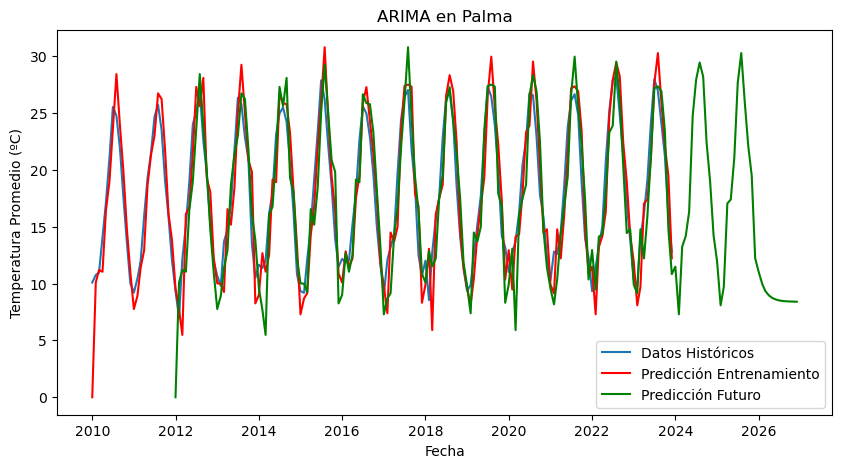

Resumen del modelo ARIMA para Las Palmas:
                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -274.412
Date:                Sat, 15 Jun 2024   AIC                            554.824
Time:                        16:32:55   BIC                            564.178
Sample:                    01-01-2010   HQIC                           558.621
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5883      0.131      4.502      0.000       0.332       0.844
ma.L1         -0.0928      0.150     -0.618      0.536      -0.387       0.201
sigma2    

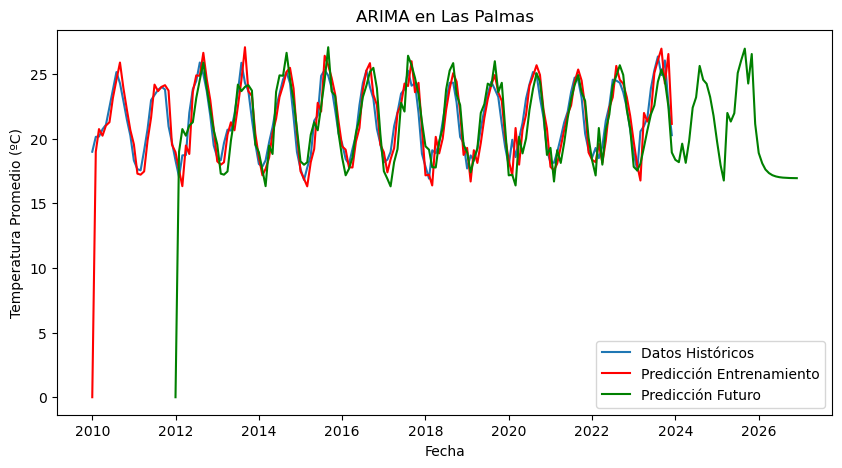

Resumen del modelo ARIMA para Girona:
                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -411.893
Date:                Sat, 15 Jun 2024   AIC                            829.786
Time:                        16:32:56   BIC                            839.140
Sample:                    01-01-2010   HQIC                           833.582
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5969      0.107      5.595      0.000       0.388       0.806
ma.L1          0.0018      0.133      0.013      0.989      -0.258       0.262
sigma2        

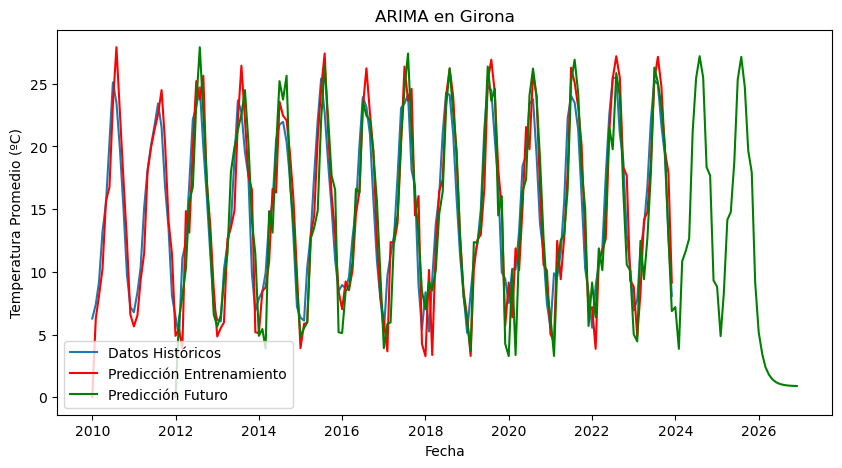

Resumen del modelo ARIMA para Malaga:
                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -352.689
Date:                Sat, 15 Jun 2024   AIC                            711.378
Time:                        16:32:56   BIC                            720.732
Sample:                    01-01-2010   HQIC                           715.175
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6301      0.092      6.839      0.000       0.449       0.811
ma.L1          0.1526      0.114      1.341      0.180      -0.070       0.376
sigma2        

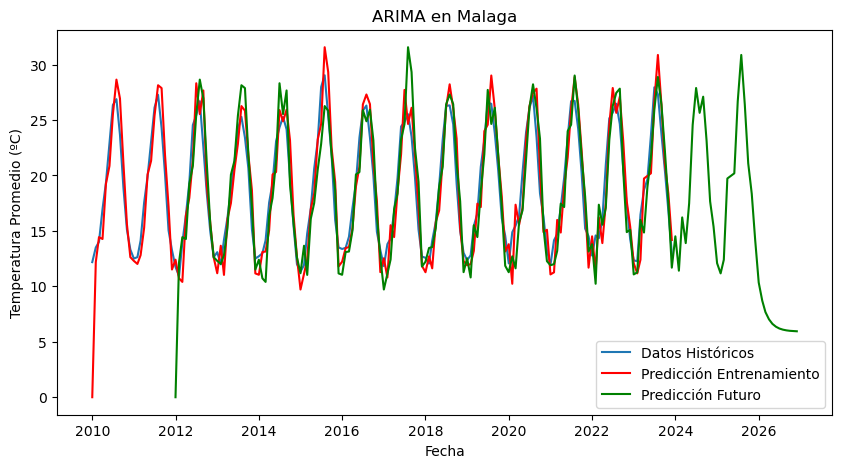

In [47]:
#ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Definir un DataFrame para almacenar las predicciones
predicciones_arima = pd.DataFrame()

# Aplicar el modelo ARIMA para cada ciudad
for city in cities.keys():
    ciudad_data = datos_todo[datos_todo['city'] == city].set_index('time')['tavg'].dropna()
    
    # Ajustar el modelo ARIMA
    model = sm.tsa.ARIMA(ciudad_data, order=(1, 1, 1))
    model_fit = model.fit()
    print(f"Resumen del modelo ARIMA para {city}:")
    print(model_fit.summary())
    
    # Predicciones dentro de la muestra
    y_pred = model_fit.predict(start=0, end=len(ciudad_data)-1, typ='levels')
    mse = mean_squared_error(ciudad_data, y_pred)
    rmse = np.sqrt(mse)
    
    # Predicciones fuera de la muestra (2024-2026)
    future_pred = model_fit.predict(start=0, end=179, typ='levels')
    future_dates = pd.date_range(start='2012-01-01', end='2026-12-01', freq='MS')
    
    # Agregar las predicciones al DataFrame
    df_pred = pd.DataFrame({'time': future_dates, 'tavg': future_pred, 'city': city})
    predicciones_arima = pd.concat([predicciones_arima, df_pred])
    aic = model_fit.aic
    print(f'ARIMA para {city} - RMSE: {rmse:.2f}')
    print(f'El valor AIC del modelo para {city} es: {aic}')
    # Graficar resultados
    plt.figure(figsize=(10, 5))
    plt.plot(ciudad_data.index, ciudad_data.values, label='Datos Históricos')
    plt.plot(ciudad_data.index, y_pred, label='Predicción Entrenamiento', color='red')
    plt.plot(future_dates, future_pred, label='Predicción Futuro', color='green')
    plt.xlabel('Fecha')
    plt.ylabel('Temperatura Promedio (ºC)')
    plt.title(f'ARIMA en {city}')
    plt.legend()
    plt.show()
    




Resumen
Obtención de Datos: Los datos se obtienen de Meteostat y se resamplean a una frecuencia mensual.
Modelos:
Regresión Lineal: Utilizamos scikit-learn para ajustar un modelo de regresión lineal.
RNN: Utilizamos tensorflow para entrenar una Red Neuronal Recurrente.
ARIMA: Utilizamos statsmodels para ajustar un modelo ARIMA.
Este enfoque te permitirá comparar diferentes modelos de series temporales para predecir la temperatura promedio mensual en diferentes ciudades.

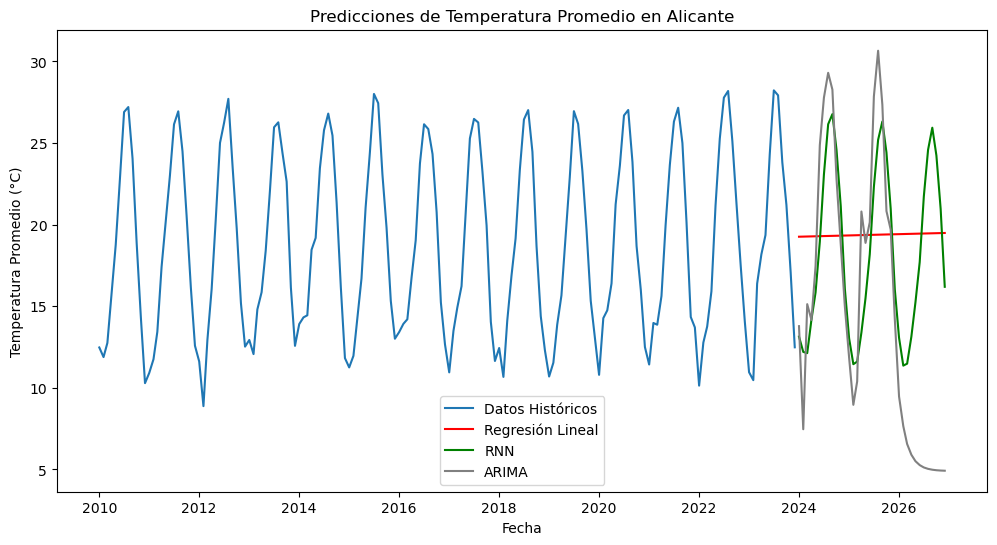

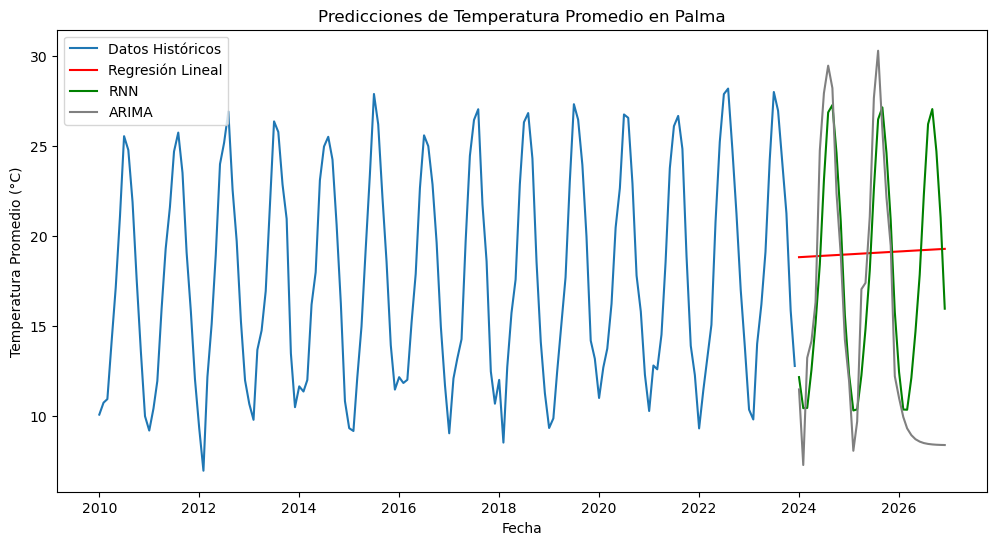

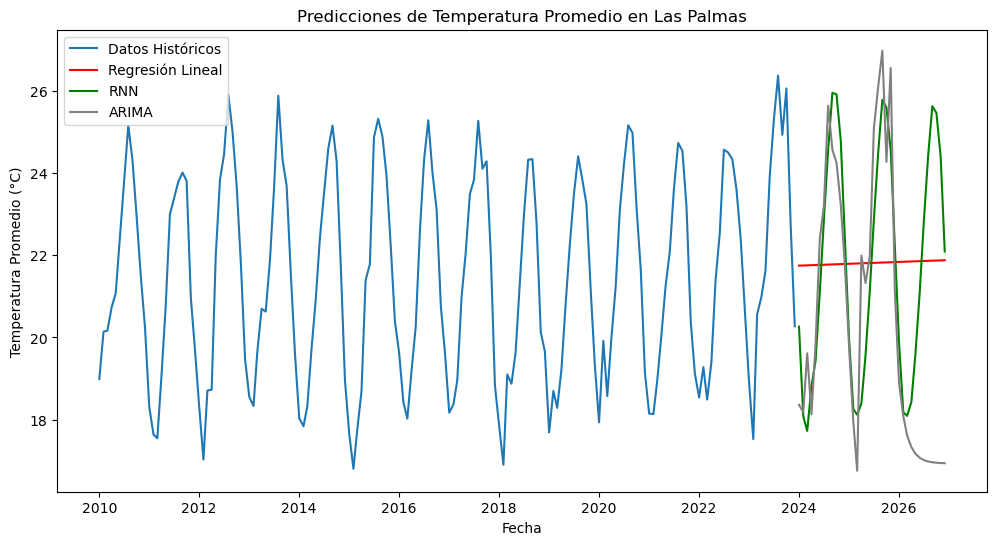

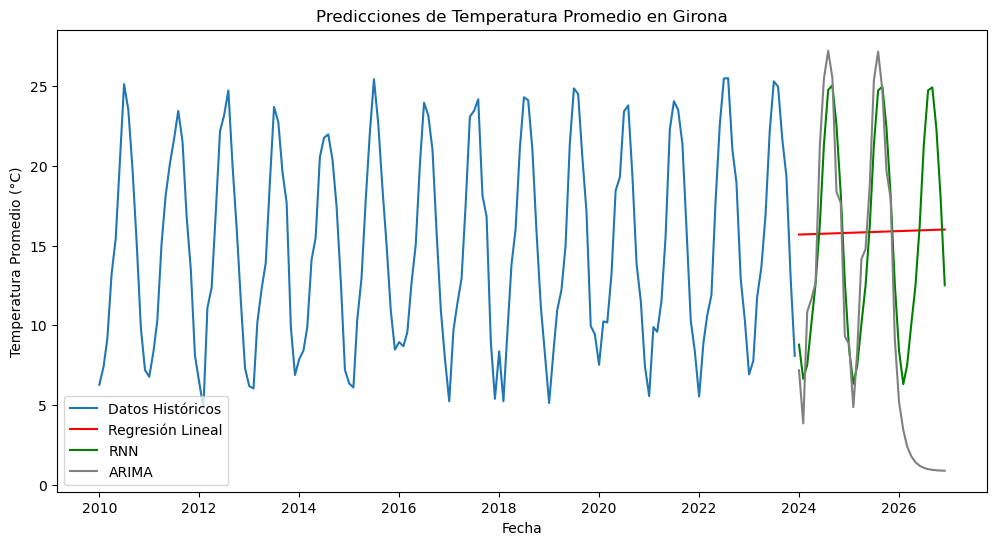

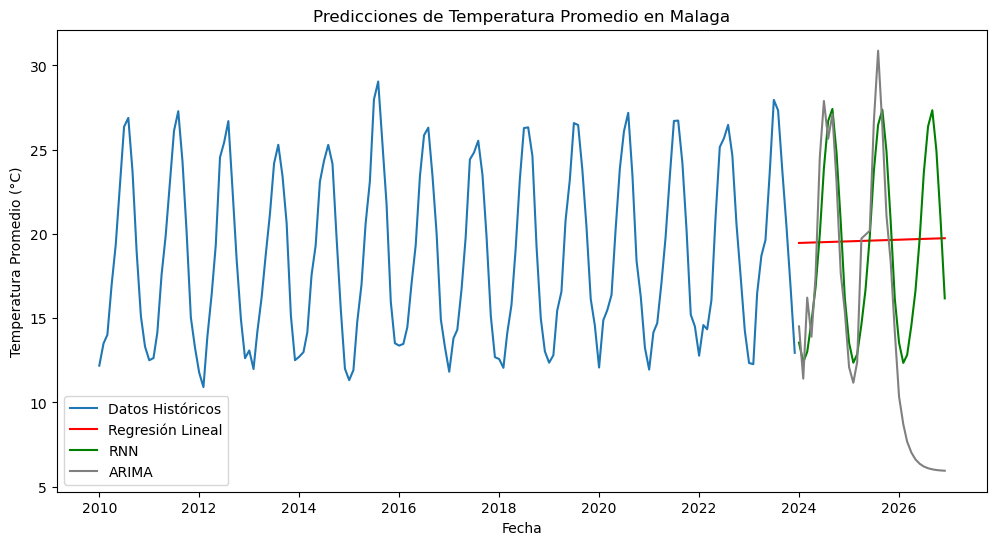

In [49]:
# Combinar todas las predicciones en un solo DataFrame
predicciones_todas = pd.concat([predicciones_regresion, predicciones_rnn, predicciones_arima])

# Graficar las predicciones para cada ciudad
for city in cities.keys():
    plt.figure(figsize=(12, 6))
    
    # Datos históricos
    ciudad_data = datos_todo[datos_todo['city'] == city].set_index('time')['tavg'].dropna()
    plt.plot(ciudad_data.index, ciudad_data.values, label='Datos Históricos')
    
    # Predicciones de Regresión Lineal
    pred_reg = predicciones_regresion[predicciones_regresion['city'] == city].set_index('time')['tavg']
    plt.plot(pred_reg.index, pred_reg.values, label='Regresión Lineal', color='red')
    
    # Predicciones de RNN
    pred_rnn = predicciones_rnn[predicciones_rnn['city'] == city].set_index('time')['tavg']
    plt.plot(pred_rnn.index, pred_rnn.values, label='RNN', color='green')
    
    # Predicciones de ARIMA
    pred_arima = predicciones_arima[(predicciones_arima['city'] == city) & (predicciones_arima['time'] > '2023-12-31')].set_index('time')['tavg']
    plt.plot(pred_arima.index, pred_arima.values, label='ARIMA', color='grey')
    
    plt.xlabel('Fecha')
    plt.ylabel('Temperatura Promedio (°C)')
    plt.title(f'Predicciones de Temperatura Promedio en {city}')
    plt.legend()
    plt.show()
